In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. Weak and strong convergence MATLAB code

- lec7_weak: Test weak convergence of a call option with underlyong as a diffusion stock price. The 1:M2:M for-loop is for memory efficiency, as it took to long to operate on 1e7-lengh array.
- lec7_strong: Test strong convergence of the stock price comparing the terminal values from h and h/2 time steps.

In [3]:
def european_call(r, sigma, T, S, K):
    log_term = np.log(S/K/np.exp(-r * T))
    vol_term = sigma*np.sqrt(T)
    d1 = log_term/vol_term + 0.5 * vol_term
    d2 = log_term/vol_term - 0.5 * vol_term
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

# 2. Python implementation to test weak/strong convergence

## 2-1 Lec7_weak

### 2-1-1 Weak Convergence

In [4]:
r, sig, T, S0, K = 0.05, 0.5, 1, 100, 110

M = int(1e7)
M2 = int(1e4)

In [5]:
V_exact = european_call(r, sig, T, S0, K)

In [6]:
%%time

hh, err1, err2 = {}, {}, {}

for p in range(6):
    N = 2**(1 + p)
    h = T/N
    sum1, sum2 = 0, 0
    # No need to separate paths in bulk, python can handle 1e7-length array
    S = S0 * np.ones((1, M))
    for n in range(N):
        dW = np.sqrt(h) * np.random.normal(size = (1, M))
        S  = S * (1 + r * h + sig * dW)
    P = np.exp(-r * T) * (S - K > 0) * (S - K)
    sum1 = sum1 + P.sum()
    sum2 = sum2 + (P**2).sum()
    
    V       = sum1/M
    sd      = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    hh[1 + p]   = h
    err1[1 + p] = V - V_exact
    err2[1 + p] = 3 * sd

CPU times: user 34.9 s, sys: 1.9 s, total: 36.8 s
Wall time: 37.1 s


In [7]:
df_errors = pd.DataFrame([hh, err1, err2]).T.rename(columns = {0: 'step',
                                                                1: 'Weak Error',
                                                                2: "MonteCarlo Error"})

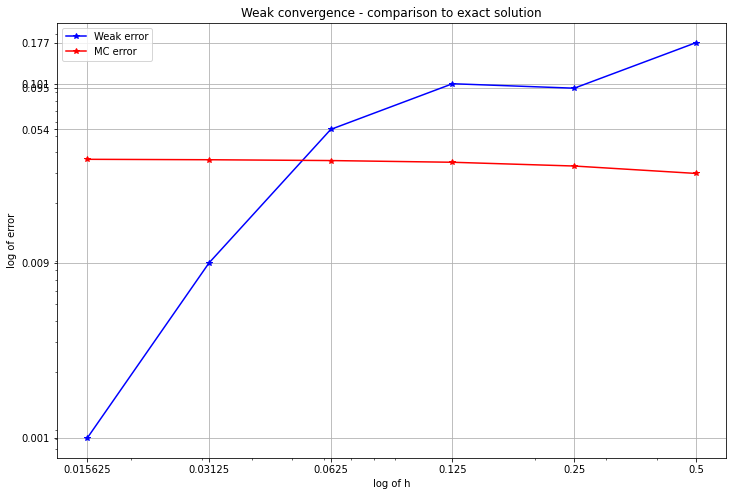

In [8]:
ax = plt.loglog(df_errors['step'], df_errors['Weak Error'].abs(),'b-*',
                df_errors['step'], df_errors['MonteCarlo Error'], 'r-*')
plt.xticks(df_errors['step'], df_errors['step'])
plt.yticks(df_errors['Weak Error'].abs(), df_errors['Weak Error'].abs().apply(lambda x:'{:0.03f}'.format(x)))

fg = plt.gcf()
fg.set_size_inches((12, 8))
plt.xlabel('log of h')
plt.ylabel('log of error')
plt.title('Weak convergence - comparison to exact solution')
plt.legend(['Weak error', 'MC error'], loc = 'upper left')
plt.grid()


### 2-1-2 Monte Carlo simulation comparing to 2h simulation

In [ ]:
%%time

M = int(1e7)
hh, err1, err2 = {}, {}, {}

for p in range(7):
    N = 2**(p + 1)
    h = T/N 
    sum1, sum2 = 0, 0
    S  = S0 * np.ones(shape = (1, M))
    S2 = S0 * np.ones(shape = (1, M))
    for n in range(int(N/2)):
        dW1 = np.sqrt(h) * np.random.normal(size = (1, M))
        S   = S * (1 + r * h + sig * dW1)
        dW2 = np.sqrt(h) * np.random.normal(size = (1, M))
        S   = S * (1 + r * h + sig * dW2)
        S2  = S2 * (1 + r*2*h + sig*(dW1 + dW2))
    P = np.exp(-r * T) * (S - K > 0) * (S - K)
    P2 = np.exp(-r * T) * (S2 - K > 0) * (S2 - K)
    
    sum1 = sum1 + (P - P2).sum()
    sum2 = sum2 + ((P - P2)**2).sum()
    Vd = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    hh[p+1] = h
    err1[p+1] = Vd
    err2[p+1] = 3 * sd

In [ ]:
df_errors_2h = pd.DataFrame([hh, err1, err2]).T.rename(columns = {0: 'step',
                                                                  1: 'Weak Error',
                                                                  2: "MonteCarlo Error"})

In [ ]:
ax = plt.loglog(df_errors_2h['step'], df_errors_2h['Weak Error'].abs(),'b-*',
                df_errors_2h['step'], df_errors_2h['MonteCarlo Error'], 'r-*')
plt.xticks(df_errors_2h['step'], df_errors_2h['step'])
plt.yticks(df_errors_2h['Weak Error'].abs(), df_errors_2h['Weak Error'].abs().apply(lambda x:'{:0.03f}'.format(x)))

fg = plt.gcf()
fg.set_size_inches((12, 8))
plt.xlabel('log of h')
plt.ylabel('log of error')
plt.title('Weak convergence - difference from 2h approximation')
plt.legend(['Weak error', 'MC error'], loc = 'upper left')
plt.grid()


## 2-2 Strong Convergence

In [ ]:
r, sig, T, S0 = 0.05, 0.5, 1, 100

M = int(1e5)

In [ ]:
%%time

hh, err1, err2, err3, err4 = {}, {}, {}, {}, {}

for p in range(7):
    N = 2**(p + 1)
    h = T/N
    sum1, sum2, sum3, sum4 = 0, 0, 0, 0
    
    S = S0 * np.ones((1, M))
    S2 = S0 * np.ones((1, M))
    W = 0
    for n in range(int(N/2)):
        dW1 = np.sqrt(h) * np.random.normal(size = (1, M))
        S   = S*(1 + r*h + sig*dW1)
        dW2 = np.sqrt(h) * np.random.normal(size = (1, M))
        S   = S*(1 + r*h + sig*dW2)
        
        S2  = S2*(1 + r*2*h + sig*(dW1 + dW2))
        W   = W + dW1 + dW2
    S_exact = S0 * np.exp((r-0.5*sig**2)*T + sig * W)
    
    diff = (S_exact - S)**2
    sum1 = sum1 + diff.sum()
    sum2 = sum2 + (diff**2).sum()
    
    diff2 = (S2 - S)**2
    sum3 = sum3 + diff2.sum()
    sum4 = sum4 + (diff2**2).sum()

    Vd = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    hh[p] = h
    err1[p] = np.sqrt(Vd)
    err2[p] = (0.5/np.sqrt(Vd) * 3*sd)
 
    Vd = sum3/M
    sd = np.sqrt((sum4/M - (sum3/M)**2)/(M-1))
    err3[p] = np.sqrt(Vd)
    err4[p] = (0.5/np.sqrt(Vd) * 3*sd)

In [ ]:
df_strong_2h = pd.DataFrame([hh, err1, err2, err3, err4]).T.rename(columns = {0:'step',
                                                                              1: 'Exact error',
                                                                              2: 'MC error w.r.t. exact',
                                                                              3: 'Relative error h v.s. 2h', 
                                                                              4: 'MC error w.r.t. relative'})

In [ ]:
plt.loglog(df_strong_2h['step'], df_strong_2h['Exact error'].abs(),'b-*',
           df_strong_2h['step'], df_strong_2h['MC error w.r.t. exact'], 'r-*',
           df_strong_2h['step'], df_strong_2h['Relative error h v.s. 2h'], 'b--o',
           df_strong_2h['step'], df_strong_2h['MC error w.r.t. relative'], 'r--o')

plt.xticks(df_strong_2h['step'], df_errors_2h['step'])
plt.yticks(df_strong_2h['MC error w.r.t. exact'].abs(), 
           df_strong_2h['MC error w.r.t. exact'].abs().apply(lambda x:'{:0.03f}'.format(x)))

fg = plt.gcf()
fg.set_size_inches((12, 8))
plt.xlabel('log of h')
plt.ylabel('log of error')
plt.title('Strong convergence -- difference from exact and 2h approximation')
plt.legend(['Exact error', 'MC error w.r.t. exact',
            'Relative error h v.s. 2h', 'MC error w.r.t. relative'], loc = 'upper left')
plt.grid()


# 3. Solving Ornstein Uhlenbeck equation

## $dS = \kappa (\theta-S)dt + \sigma dW$

## Analytical form $S_t = e^{-\kappa t}S_0 + \theta(1-e^{-\kappa t}) + \sigma\int_0^{t}e^{-\kappa(t-s)}dW_s$

Fixing time $t$, $S_t$ is a Gaussian distribution, with mean $e^{-\kappa t}S_0 + \theta(1-e^{-\kappa t})$ and variance $\frac{\sigma^2}{2\kappa}(1-e^{-2\kappa t})$. 

### We can still test its weak convergence.

In [ ]:
S0, theta, kappa, sigma = 100, 110, 2, 0.5
T = 1

M = int(1e5)

mean_exact = np.exp(-kappa * T)*S0 + theta * (1 - np.exp(-kappa*T))
var_exact  = sigma**2/kappa*(1 - np.exp(-2*kappa*T))

In [ ]:
mean_exact, var_exact

In [ ]:
%%time

hh, err1, err2, err3, err4 = {}, {}, {}, {}, {}

for p in range(12):
    N = 2**(p + 1)
    h = T/N
    sum1, sum2, sum3, sum4 = 0, 0, 0, 0
    
    S = S0 * np.ones((1, M))
    S2 = S0 * np.ones((1, M))
    W = 0
    
    for n in range(int(N/2)):
        dW1 = np.sqrt(h) * np.random.normal(size = (1, M))
        S   = S + kappa*(theta-S)*h + sig*dW1
        dW2 = np.sqrt(h) * np.random.normal(size = (1, M))
        S   = S + kappa*(theta-S)*h + sig*dW2
        
        S2  = S2 + kappa*(theta-S2)*2*h + sig*(dW1 + dW2)
        W   = W + dW1 + dW2
    
    diff = (mean_exact - S)
    sum1 = sum1 + diff.sum()
    sum2 = sum2 + (diff**2).sum()
    
    diff2 = (S2 - S)**2
    sum3 = sum3 + diff2.sum()
    sum4 = sum4 + (diff2**2).sum()

    Weak_Error = sum1/M
    
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    hh[p] = h
    err1[p] = Weak_Error
    err2[p] = 3*sd
 
    Vd = sum3/M
    sd = np.sqrt((sum4/M - (sum3/M)**2)/(M-1))
    err3[p] = np.sqrt(Vd)
    err4[p] = (0.5/np.sqrt(Vd) * 3*sd)

In [ ]:
df_OU_2h = pd.DataFrame([hh, err1, err2, err3, err4]).T.rename(columns = {0:'step',
                                                                              1: 'Weak error',
                                                                              2: 'MC error Weak',
                                                                              3: 'Relative strong error h v.s. 2h', 
                                                                              4: 'MC error w.r.t. relative'})

In [ ]:
plt.loglog(df_OU_2h['step'], df_OU_2h['Weak error'].abs(),'b-*',
           df_OU_2h['step'], df_OU_2h['MC error Weak'], 'r-*',
           df_OU_2h['step'], df_OU_2h['Relative strong error h v.s. 2h'], 'b--o',
           df_OU_2h['step'], df_OU_2h['MC error w.r.t. relative'], 'r--o')

plt.xticks(df_OU_2h['step'], df_OU_2h['step'])
plt.yticks(df_OU_2h['Weak error'].abs(), 
           df_OU_2h['Weak error'].abs().apply(lambda x:'{:0.03f}'.format(x)))

fg = plt.gcf()
fg.set_size_inches((12, 8))
plt.xlabel('log of h')
plt.ylabel('log of error')
plt.title('Strong and weak convergence -- difference from h and 2h approximation')
plt.legend(df_OU_2h.columns[1:], loc = 'upper left')
plt.grid()


### Summary: Weak error ~ O(h), Strong error ~ O($\sqrt{h}$) from the above graphs, as the coeffients are Lipschitz w.r.t. S

#  4. Heston model with a pair of SDEs

$dS = rSdt + \sqrt{|v|}SdW^{(1)}$

$dv = \kappa(\theta-v)dt + \xi\sqrt{|v|}dW^{(2)}$

$d<W^{(1)}, W^{(2)}>_t = \rho dt, \rho = -0.1$

In [ ]:
S0, v0, theta, kappa, xi = 100, 0.25, 0.25, 2, 0.5

cov = np.array([[1, -0.1], 
                [-0.1, 1]])

In [ ]:
%%time

hh, err1, err2 = {}, {}, {}

for p in range(12):
    N = 2**(p + 1)
    h = T/N
    sum1, sum2 = 0, 0
    
    S = S0 * np.ones((1, M))
    S2 = S0 * np.ones((1, M))
    
    
    v = v0 * np.ones((1, M))
    v2 = v0 * np.ones((1, M))
    
    W_S, W_v = 0, 0
    
    for n in range(int(N/2)):
        dW_S_1, dW_v_1 = [x for x in np.sqrt(h) * np.random.multivariate_normal(mean = [0, 0], cov = cov, size = M).T]
        S   = S * (1 + r * h + np.sqrt(np.abs(v)) * dW_S_1)
        v   = v + kappa * (theta-v)*h + xi * np.sqrt(np.abs(v)) * dW_v_1

        dW_S_2, dW_v_2 = [x for x in np.sqrt(h) * np.random.multivariate_normal(mean = [0, 0], cov = cov, size = M).T]
        S   = S * (1 + r * h + np.sqrt(np.abs(v)) * dW_S_2)
        v   = v + kappa * (theta-v)*h + xi * np.sqrt(np.abs(v)) * dW_v_2

        S2   = S2 * (1 + r * 2* h + np.sqrt(np.abs(v2)) * (dW_S_1 + dW_S_2))
        v2   = v2 + kappa * (theta-v2)*2*h + xi * np.sqrt(np.abs(v2)) * (dW_v_1 + dW_v_2)

    diff = (S2 - S)**2
    sum1 = sum1 + diff.sum()
    sum2 = sum2 + (diff**2).sum()

    Vd = sum1/M

    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    hh[p]   = h
    err1[p] = np.sqrt(Vd)
    err2[p] = (0.5/np.sqrt(Vd) * 3*sd)

In [ ]:
df_Heston_2h = pd.DataFrame([hh, err1, err2]).T.rename(columns = {0:'step',
                                                                  1: 'Relative strong error h v.s. 2h', 
                                                                  2: 'MC error w.r.t. relative'})

In [ ]:
plt.loglog(df_Heston_2h['step'], df_Heston_2h['Relative strong error h v.s. 2h'].abs(),'b-*',
           df_Heston_2h['step'], df_Heston_2h['MC error w.r.t. relative'], 'r-*')

plt.xticks(df_Heston_2h['step'], df_Heston_2h['step'])
plt.yticks(df_Heston_2h['Relative strong error h v.s. 2h'].abs(), 
           df_Heston_2h['Relative strong error h v.s. 2h'].abs().apply(lambda x:'{:0.03f}'.format(x)))

fg = plt.gcf()
fg.set_size_inches((12, 8))
plt.xlabel('log of h')
plt.ylabel('log of error')
plt.title('Strong convergence -- difference from h and 2h approximation')
plt.legend(df_OU_2h.columns[1:], loc = 'upper left')
plt.grid()


### Strong convergence rate is $O(\sqrt{h})$

To do: structure the code better as for now there are a lot of duplications, which can be substituted by a class of a function